# BC4 

Apex Pattern Deployers

- Marjorie Kinney *m20210647*
- Bruno Mendes *m20210627*
- Lucas Neves *m20211020*
- Farina Pontejos *m20210649*

Business Cases for Data Science

NOVA Information Management School

May 2022

https://github.com/fpontejos/bc4


## Initial Setup

### Imports

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from math import ceil
from datetime import timedelta, datetime
import os
import re
import warnings
import itertools
import collections
import ta

warnings.filterwarnings('ignore')



In [2]:
from matplotlib.colors import LinearSegmentedColormap


In [3]:
from functools import reduce

In [4]:
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif

from sklearn.preprocessing import StandardScaler, MinMaxScaler


from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import SCORERS
from sklearn.linear_model import LinearRegression, BayesianRidge

In [5]:
from xgboost import XGBRegressor

In [6]:
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()


### Variables

In [7]:
COLORS = ['#2ec4b6', '#1e9fb4', '#0f7ab2', '#285892', '#49306b', '#7a3161', '#a13258', '#c63351', '#ea3449']

CAT_COLORS = ['#2EC4B6', '#0E79B2', '#49306B', '#9A325A', '#EA3449']
CONTRAST_COLORS = [COLORS[i] for i in range(len(COLORS)) if (i%2) == 0]

DIV_COLORS = ['#0e79b2', '#4b9ac3', '#84b8d4', '#bcd6e4', '#f4f4f4', '#c6c0d0', '#9b8eac', '#715e8b', '#49306b']

DIV_COL_HALF = ['#f4f4f4', '#bed3da', '#8ab2bf', '#5592a5', '#20718b']

UMP_COLORS = ['#22446D', '#FC9E4F', '#AB2346' ,'#6ABB5D']

DEFAULT_PALETTE = sns.color_palette(COLORS)
CONTRAST_PALETTE = sns.color_palette(CONTRAST_COLORS)
DIVERGENT_PALETTE = sns.color_palette(DIV_COLORS)
DIVHALF_PALETTE = sns.color_palette(DIV_COL_HALF)
CAT_PALETTE = sns.color_palette(CAT_COLORS)
UMP_PALETTE = sns.color_palette(UMP_COLORS)


DIV_CMAP = LinearSegmentedColormap.from_list("div_colors", DIV_COLORS)
DIV_H_CMAP = LinearSegmentedColormap.from_list("div_colors", DIV_COL_HALF)
CAT_CMAP = LinearSegmentedColormap.from_list("cat_colors", CAT_COLORS)
UMP_CMAP = LinearSegmentedColormap.from_list("ump_colors", UMP_COLORS)


SHOW_PLOTS = True
SAVE_PLOTS = True
RANDOM_STATE = 9

IMG_PATH = '../imgs/'
DATA_IN_PATH = '../../source/data/'
DATA_OUT_PATH = '../../data_out/'


In [8]:
def save_fig(title, fig):
    if SAVE_PLOTS == True:
        fn = IMG_PATH + title.replace(' ','-') + '.png'
        fig.savefig(fn, bbox_inches='tight', transparent=True)
        


### Styles

In [9]:
sns.set(style="white")

sns.set_context("paper")
sns.set_palette(DEFAULT_PALETTE)


plt.rcParams['figure.dpi'] = 128

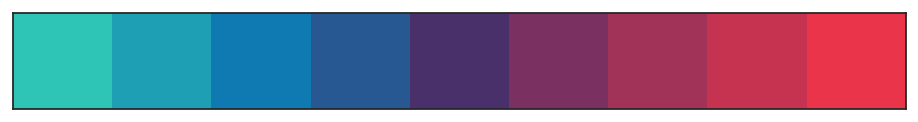

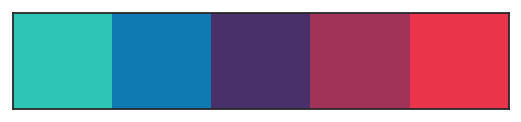

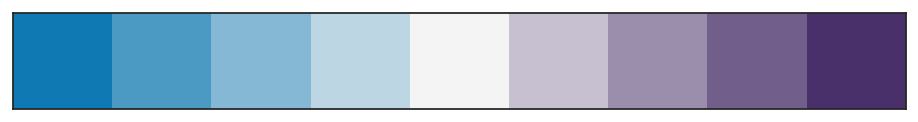

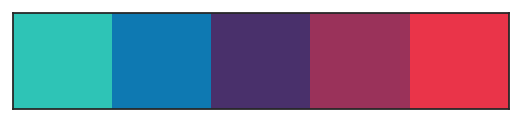

In [10]:
sns.palplot(DEFAULT_PALETTE)
sns.palplot(CONTRAST_PALETTE)
sns.palplot(DIVERGENT_PALETTE)
sns.palplot(CAT_PALETTE)
plt.show()

## Load Data

In [11]:
df_all = pd.read_csv(DATA_OUT_PATH + "merged_data.csv")
df_all.head(3)

,Date,ada_close,ada_high,ada_low,ada_open,ada_volume,atom_close,atom_high,atom_low,atom_open,...,luna1_trend_macd,luna1_volatility_atr,matic_volume_obv,matic_momentum_rsi,matic_trend_macd,matic_volatility_atr,sol_volume_obv,sol_momentum_rsi,sol_trend_macd,sol_volatility_atr
0,2021-01-01,0.175350,0.184246,0.172022,0.181382,1.122218e+09,5.868556,6.506998,5.652401,6.490297,...,0.053993,0.051369,2.036519e+09,47.984858,-0.000144,0.001536,255658268.0,57.385950,-0.050738,0.191277
1,2021-01-02,0.177423,0.184253,0.169233,0.175359,1.408850e+09,5.414613,5.882211,5.319140,5.869282,...,0.053286,0.049277,2.053894e+09,53.344082,-0.000058,0.001609,223987204.0,55.832142,-0.027803,0.198930
2,2021-01-03,0.204995,0.208679,0.173376,0.177382,2.303858e+09,5.813898,5.900645,5.301713,5.416301,...,0.054555,0.049605,2.071803e+09,56.959753,0.000084,0.001614,279060626.0,64.577875,0.019398,0.235608


In [12]:
df_all['Date'] = pd.to_datetime(df_all['Date'])

## Use only 2022 data
df_all = df_all.loc[df_all['Date']>='01-01-2022']

In [13]:

## How much data to use for model selection crossval
## Jan Feb March for training; Use April for prediction
TRAIN_SIZE = 90

## How large the timeseriessplit window should be
WINDOW_SIZE = 7

## How many days for cv test
TEST_SIZE = 1

In [14]:
#df_all

In [15]:
def shift_split_data(df, target_col, trainsize):
    ## Date_Y is the date being predicted
    ## The corresponding Date_X of the same row is the previous date
    df['Date_Y'] = df['Date']+ pd.DateOffset(days=1) 
    df['Y'] = df[target_col].shift(periods=-1)
    df.rename(columns={'Date':'Date_X'}, inplace=True)
    
    ## DF for prediction (only last trainsize days)
    ## Use to predict day after last df Date
    df_forprediction = df.iloc[trainsize:]
    
    ## DF for train + test (without last trainsize days)
    df_tt = df.iloc[:trainsize]
    
    return df_tt, df_forprediction
    
    

In [16]:
target_cols = [i for i in df_all if '_close' in i]

In [17]:
target_col = 'btc_close'

In [18]:
df_tt, df_forprediction = shift_split_data(df_all, target_col, TRAIN_SIZE)

In [19]:
#df_tt

In [20]:
#df_forprediction

In [21]:
df_forprediction['Date_X'] = pd.to_datetime(df_forprediction['Date_X'])
df_tt['Date_X'] = pd.to_datetime(df_tt['Date_X'])


df_forprediction['Date_Y'] = pd.to_datetime(df_forprediction['Date_Y'])
df_tt['Date_Y'] = pd.to_datetime(df_tt['Date_Y'])


In [22]:
df_tt.set_index('Date_Y', inplace=True)
df_forprediction.set_index('Date_Y', inplace=True)

## Baseline Model

In [23]:
## Baseline model is simply yesterday's price as prediction for today

pred_baseline = df_tt[['Y']].shift()


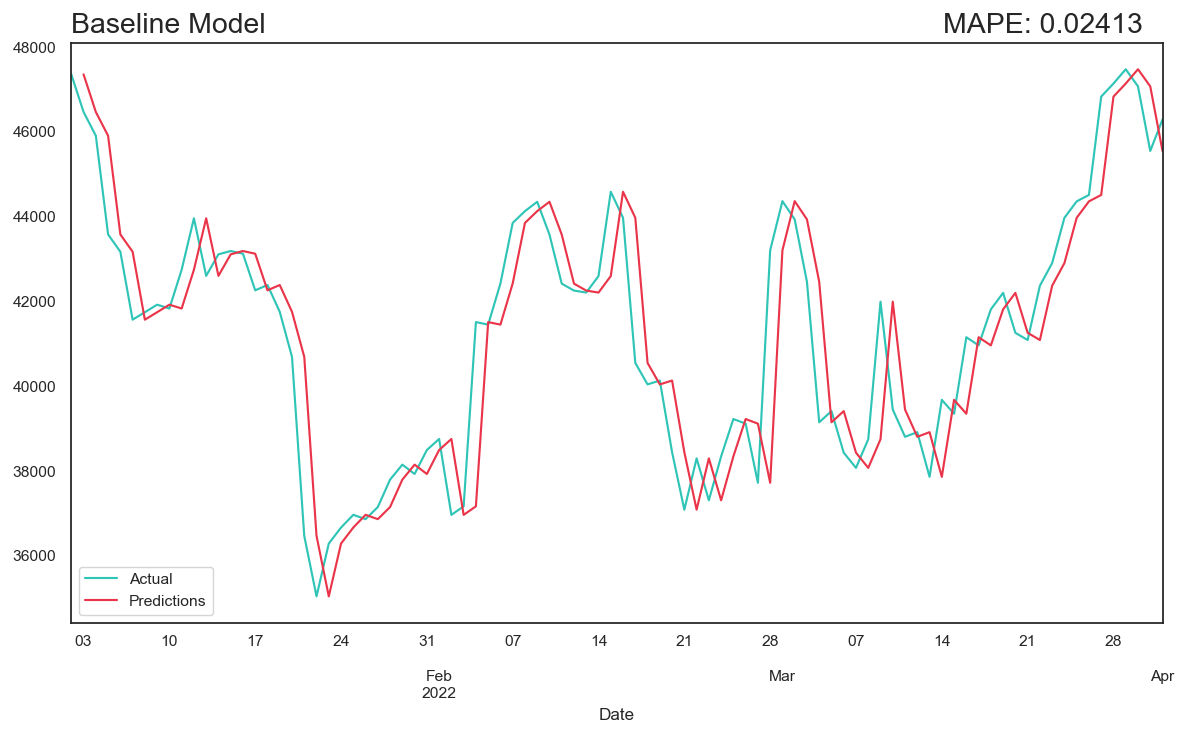

In [24]:
def plot_baseline(pred, actual, title='Baseline Model', mape=None):
    fig, ax = plt.subplots(figsize=(11, 6), sharex=True)

    ## Plot actual test
    actual.plot(ax=ax, label='Actual', color=CAT_COLORS[0])

    ## Plot predictions
    pred.plot(ax=ax, label='Predictions', color=CAT_COLORS[-1])
    

    mape_ = ""
    ax.legend();
    if mape != None :
        mape_ = "Train MAPE: " + str(abs(round(mape,5)))
    else:
        mape_ = "MAPE: " + str(round(mean_absolute_percentage_error(actual[1:-1],pred[1:-1]),5))
        
    ax.set_title(title, loc='left', fontsize=16)
    ax.annotate(mape_,
            xy=(1, 1), xycoords='axes fraction',
            xytext=(-20, 30), textcoords='offset pixels',
                fontsize=16,
            horizontalalignment='right',
            verticalalignment='top')
    
    
    ax.set_xlabel("Date")
    plt.show()
    
    save_fig(title, fig)
    
plot_baseline(pred_baseline['Y'], df_tt['Y'], 'Baseline Model')

In [25]:
### Plot predictions vs actual

In [26]:
def plot_predictions(pred, actual, title='Prediction vs Actual', mape=None):
    fig, axes = plt.subplots(2,1,figsize=(11, 6), sharex=True)

    ## Plot actual test
    actual.plot(ax=axes[0], label='Actual', color=CAT_COLORS[0])

    ## Plot predictions
    pred.plot(ax=axes[0], label='Predictions', color=CAT_COLORS[-1])
    
    df_diff = pd.DataFrame([pred]).T.rename(columns={'Y':'pred'})
    df_diff['actual'] = actual
    df_diff['diff'] = (df_diff['actual'] - df_diff['pred'])/df_diff['actual']
    df_diff['baseline'] = (df_diff['actual'] - pred_baseline['Y'])/df_diff['actual']

    mape_ = ""
    axes[0].legend();
    if mape != None :
        mape_ = "Train MAPE: " + str(abs(round(mape,5)))
    else:
        mape_ = "MAPE: " + str(round(mean_absolute_percentage_error(actual[1:-1],pred[1:-1]),5))
        
    axes[0].set_title(title, loc='left', fontsize=16)
    axes[0].annotate(mape_,
            xy=(1, 1), xycoords='axes fraction',
            xytext=(-20, 30), textcoords='offset pixels',
                fontsize=16,
            horizontalalignment='right',
            verticalalignment='top')
    
    df_diff['baseline'].plot(ax=axes[1], label='Baseline Error', color=CAT_COLORS[1])
    df_diff['diff'].plot(ax=axes[1], label='Model Error', color=CAT_COLORS[-1], linestyle='dashed')
    axes[1].set_title(title+'Error vs Baseline Error', loc='left', fontsize=16)
    
    axes[1].legend();
    
    axes[1].set_xlabel("Date")
    plt.show()
    
    save_fig(title, fig)
    


In [27]:
def get_model_scores(results):
    """ 
    Returns list of scores from gridsearch
    """
    cv_res = pd.DataFrame(results).sort_values(by='rank_test_score').iloc[0:1]
    cv_res_scores = [i for i in cv_res.columns.tolist() if "split" in i]
    cv_res_scores_list = cv_res.loc[:,cv_res_scores].T.reset_index(drop=True).iloc[:,0]
    return cv_res_scores_list

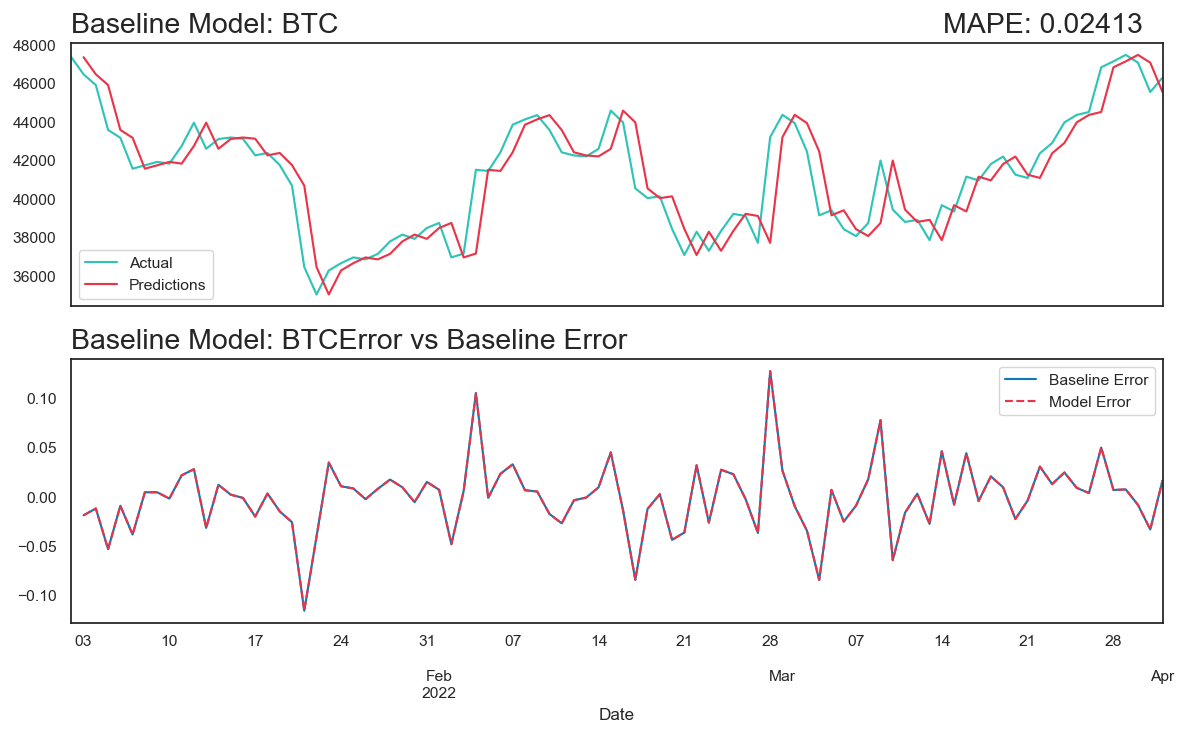

In [28]:
plot_predictions(pred_baseline['Y'], df_tt['Y'], 'Baseline Model: BTC')

In [29]:
#mean_absolute_percentage_error(pred_baseline['Y'], df_forprediction['Y'])

## Model Selection: ML Models

In [30]:
#SCORERS.keys()

In [31]:
target_cols = [i for i in df_all.columns if '_close' in i]

In [32]:
baseline_scores = [round(mean_absolute_percentage_error(pred_baseline['Y'][1:-1],df_tt['Y'][1:-1]),6) for i in range(10)]
model_scores = pd.DataFrame(baseline_scores, columns=['Baseline'])
#model_scores

In [33]:
#df_tt.head(5)

In [34]:
def get_predictions(gs_, title):   
    best_estimator_ = gs_.best_estimator_
    df_ = df_tt
    preds_ = []
    for i in range(len(df_)-WINDOW_SIZE):
        i_ = i+WINDOW_SIZE
        best_estimator_.fit(df_[x_cols][i:i_], df_['Y'][i:i_])
        b_ = best_estimator_.predict(df_[x_cols][i_:i_+1])    
        preds_.append(b_[0])


    ## Plot predictions using April+ fit
    preds_df = pd.DataFrame(preds_, index=df_[WINDOW_SIZE:].index)
    vals_ = df_[['Y']]
    vals_['pred'] = preds_df[0]
    plot_predictions(vals_['pred'], vals_['Y'], title, gs_.best_score_)
    return



### Set up pipeline

In [35]:
score_func = 'neg_mean_absolute_percentage_error'

In [36]:
## Split X and Y

Y = df_tt['Y']

x_cols = [i for i in df_tt.columns.tolist() if i not in ['Date_X', 'Date_Y', 'Y'] ]
X = df_tt[x_cols]

In [37]:
## Setup TimeSeriesSplit
num_splits = int(len(X)/(WINDOW_SIZE+TEST_SIZE))

tscv = TimeSeriesSplit(n_splits=num_splits, max_train_size=WINDOW_SIZE, test_size=TEST_SIZE)


### DecisionTreeRegressor

In [38]:
pipe_dt = make_pipeline(StandardScaler(),
                    SelectKBest(f_regression),
                    DecisionTreeRegressor(random_state=RANDOM_STATE))

## Change params as needed
params_dt = {
    'selectkbest__k':[5,10,20,30,40,45,50,55,60],
    'decisiontreeregressor__max_depth': [1,2,3,4,5],
}



# Setting up the grid search
gs_dtr = GridSearchCV(pipe_dt, 
                      params_dt, 
                      n_jobs=-1, 
                      cv=tscv,
                      scoring=score_func,
                      refit=True
                     )



In [39]:
# Fit GS to training data
gs_dtr.fit(X, Y)
df_cv_scores = pd.DataFrame(gs_dtr.cv_results_).sort_values(by='rank_test_score').loc[:,['mean_test_score', 'params', 'rank_test_score']]


In [40]:
#model_scores['DecisionTreeRegressor'] = get_model_scores(gs_dtr.cv_results_)

In [41]:
#model_scores

In [42]:
gs_dtr.best_params_

{'decisiontreeregressor__max_depth': 2, 'selectkbest__k': 50}

In [43]:
best_estimator_dtr = gs_dtr.best_estimator_
best_estimator_dtr.fit(df_forprediction[x_cols][:-1], df_forprediction['Y'][:-1])

## Make prediction for last
best_estimator_dtr.predict(df_forprediction[x_cols][-1:])

array([40246.94391741])

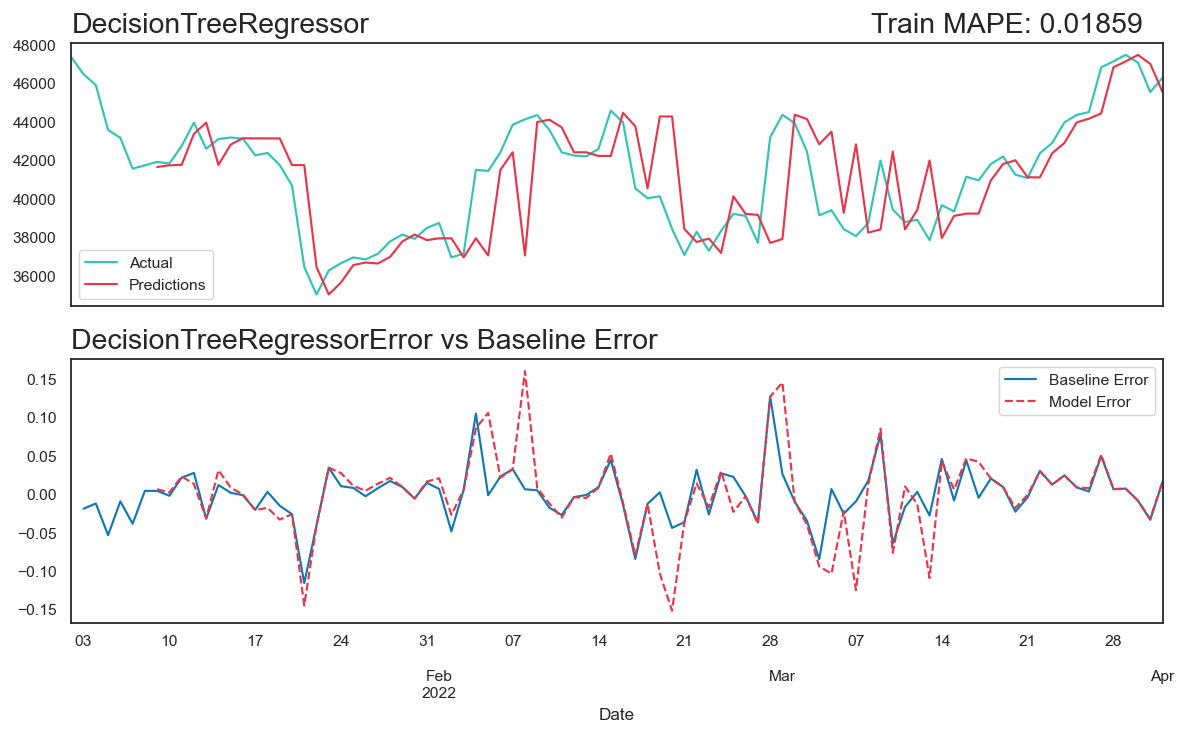

In [44]:
get_predictions(gs_dtr, 'DecisionTreeRegressor')

### MLPRegressor

In [45]:
params_mlp = {
    'mlpregressor__activation': ['logistic'],
    'mlpregressor__max_fun': [1000],
    'mlpregressor__solver': ['lbfgs'],
    'selectkbest__k': [50]
}

pipe_mlp = make_pipeline(MinMaxScaler(),
                    SelectKBest(f_regression),
                    MLPRegressor(random_state=RANDOM_STATE, max_iter=2000))


# Setting up the grid search
gs_mlp = GridSearchCV(pipe_mlp, 
                      params_mlp, 
                      n_jobs=-1, 
                      cv=tscv,
                      scoring=score_func,
                      refit=True
                     )

gs_mlp.fit(X, Y)

/opt/homebrew/Caskroom/miniforge/base/envs/dm/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/homebrew/Caskroom/miniforge/base/envs/dm/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/homebrew/Caskroom/miniforge/base/envs/dm/lib/python3.9/site-packages/sklearn/neural_network

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=7, n_splits=11, test_size=1),
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x11f666940>)),
                                       ('mlpregressor',
                                        MLPRegressor(max_iter=2000,
                                                     random_state=9))]),
             n_jobs=-1,
             param_grid={'mlpregressor__activation': ['logistic'],
                         'mlpregressor__max_fun': [1000],
                         'mlpregressor__solver': ['lbfgs'],
                         'selectkbest__k': [50]},
             scoring='neg_mean_absolute_percentage_error')

In [46]:
best_estimator_mlp = gs_mlp.best_estimator_
best_estimator_mlp.fit(df_forprediction[x_cols][:-1], df_forprediction['Y'][:-1])


Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('selectkbest',
                 SelectKBest(k=50,
                             score_func=<function f_regression at 0x11f666940>)),
                ('mlpregressor',
                 MLPRegressor(activation='logistic', max_fun=1000,
                              max_iter=2000, random_state=9, solver='lbfgs'))])

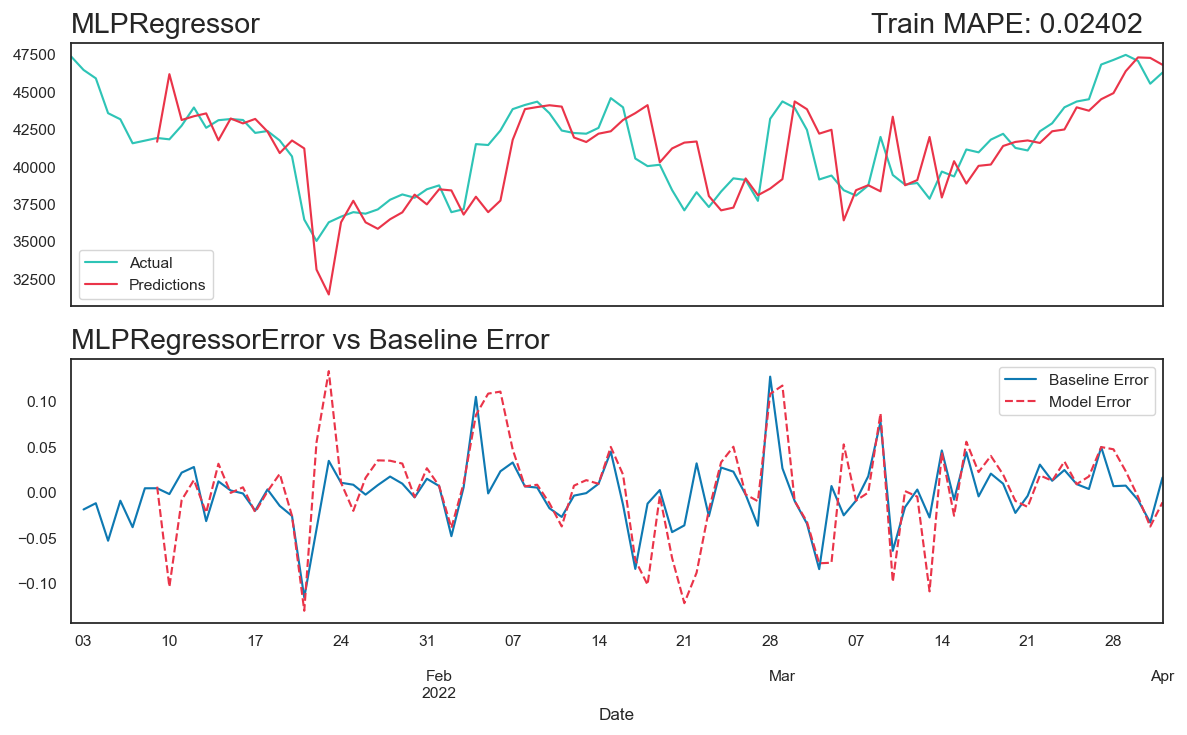

In [47]:
get_predictions(gs_mlp, 'MLPRegressor')

### Gradient Boost Regressor

In [48]:
params_gbr = {
 'gradientboostingregressor__learning_rate': [0.13],
 'gradientboostingregressor__loss': ['quantile'],
 'gradientboostingregressor__max_depth': [1],
 'gradientboostingregressor__max_features': ['auto'],
 'gradientboostingregressor__n_estimators': [296],
 'selectkbest__k': [17]}

pipe_gbr = make_pipeline(StandardScaler(),
                    SelectKBest(f_regression),
                    GradientBoostingRegressor(random_state=RANDOM_STATE))


# Setting up the grid search
gs_gbr = GridSearchCV(pipe_gbr, 
                      params_gbr, 
                      n_jobs=-1, 
                      cv=tscv,
                      scoring=score_func,
                      refit=True
                     )

gs_gbr.fit(X, Y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=7, n_splits=11, test_size=1),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x11f666940>)),
                                       ('gradientboostingregressor',
                                        GradientBoostingRegressor(random_state=9))]),
             n_jobs=-1,
             param_grid={'gradientboostingregressor__learning_rate': [0.13],
                         'gradientboostingregressor__loss': ['quantile'],
                         'gradientboostingregressor__max_depth': [1],
                         'gradientboostingregressor__max_features': ['auto'],
                         'gradientboostingregressor__n_estimators': [296],
                         'selectkbest__k': [17]},
             scoring='neg_mean_absolute_percentage_error')

In [49]:
best_estimator_gbr = gs_gbr.best_estimator_
best_estimator_gbr.fit(df_forprediction[x_cols][:-1], df_forprediction['Y'][:-1])


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(k=17,
                             score_func=<function f_regression at 0x11f666940>)),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(learning_rate=0.13, loss='quantile',
                                           max_depth=1, max_features='auto',
                                           n_estimators=296, random_state=9))])

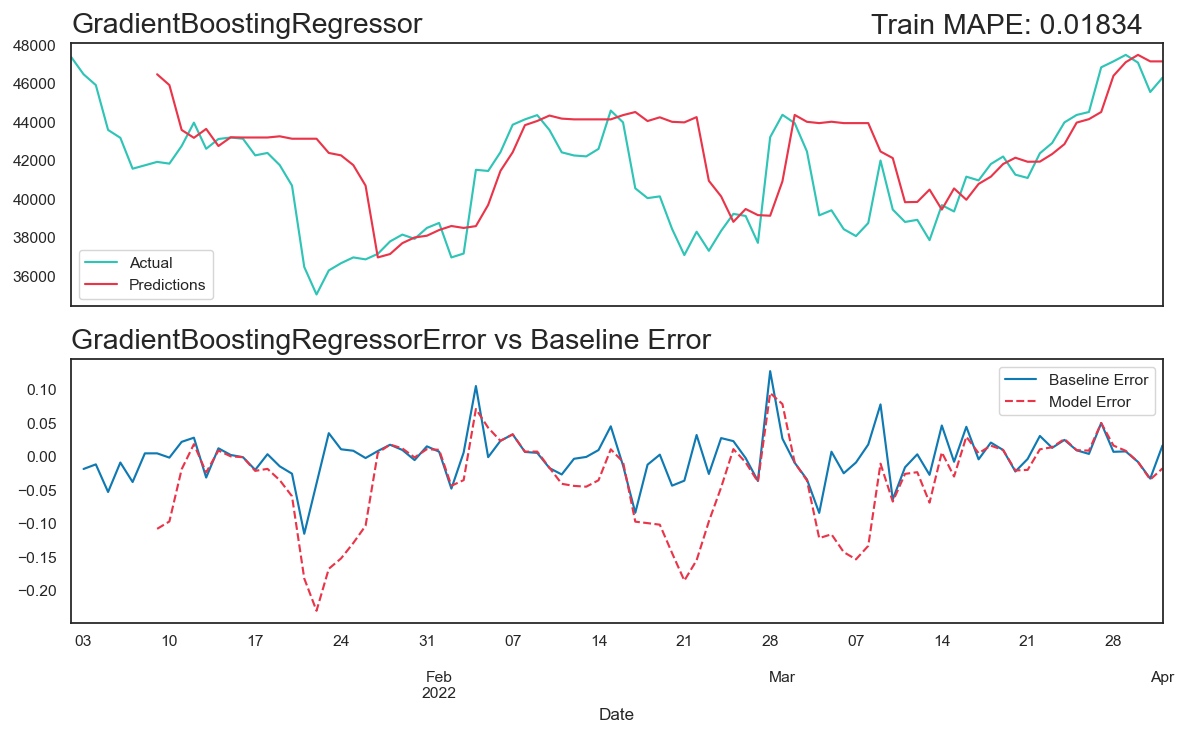

In [50]:
get_predictions(gs_gbr, 'GradientBoostingRegressor')

### XGBRegressor

In [51]:
params_xgb = {
    'selectkbest__k':[40],
    'xgbregressor__learning_rate': [1],
    'xgbregressor__max_depth': [3],
    
}

pipe_xgb = make_pipeline(StandardScaler(),
                    SelectKBest(f_regression),
                    XGBRegressor(random_state=RANDOM_STATE))


# Setting up the grid search
gs_xgb = GridSearchCV(pipe_xgb, 
                      params_xgb, 
                      n_jobs=-1, 
                      cv=tscv,
                      scoring=score_func,
                      refit=True
                     )

gs_xgb.fit(X, Y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=7, n_splits=11, test_size=1),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x11f666940>)),
                                       ('xgbregressor',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     enable_...
                                                     n_estimators=100,
                                                     n_jobs=None,
                                                     num

In [52]:
gs_xgb.best_params_

{'selectkbest__k': 40,
 'xgbregressor__learning_rate': 1,
 'xgbregressor__max_depth': 3}

In [53]:
best_estimator_xgb = gs_xgb.best_estimator_
best_estimator_xgb.fit(df_forprediction[x_cols][:-1], df_forprediction['Y'][:-1])


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(k=40,
                             score_func=<function f_regression at 0x11f666940>)),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, enable_categorical=False,
                              gamma=0, gpu_id=-1, importance_type=None,
                              interaction_constraints='', learning_rate=1,
                              max_delta_step=0, max_depth=3, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=100, n_jobs=8, num_parallel_tree=1,
                              predictor='auto', random_state=9, reg_alpha=0,
                              reg_lambda=1, scale_pos_weight=1, subsample=1,
                      

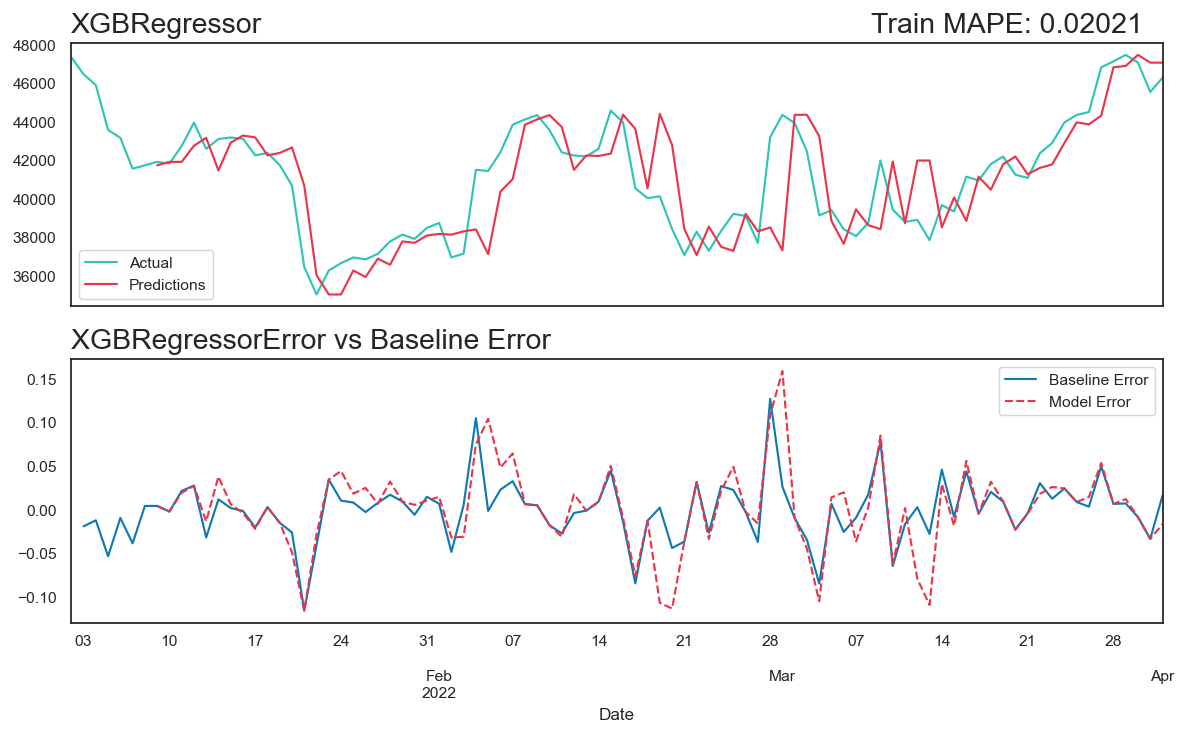

In [54]:
get_predictions(gs_xgb, 'XGBRegressor')

### KNeighborsRegressor

In [55]:
params_knr = {'kneighborsregressor__leaf_size': [10],
 'kneighborsregressor__n_neighbors': [3],
 'selectkbest__k': [10]}

pipe_knr = make_pipeline(StandardScaler(),
                    SelectKBest(f_regression),
                    KNeighborsRegressor())


# Setting up the grid search
gs_knr = GridSearchCV(pipe_knr, 
                      params_knr, 
                      n_jobs=-1, 
                      cv=tscv,
                      scoring=score_func,
                      refit=True
                     )

gs_knr.fit(X, Y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=7, n_splits=11, test_size=1),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x11f666940>)),
                                       ('kneighborsregressor',
                                        KNeighborsRegressor())]),
             n_jobs=-1,
             param_grid={'kneighborsregressor__leaf_size': [10],
                         'kneighborsregressor__n_neighbors': [3],
                         'selectkbest__k': [10]},
             scoring='neg_mean_absolute_percentage_error')

In [56]:
best_estimator_knr = gs_knr.best_estimator_
best_estimator_knr.fit(df_forprediction[x_cols][:-1], df_forprediction['Y'][:-1])


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x11f666940>)),
                ('kneighborsregressor',
                 KNeighborsRegressor(leaf_size=10, n_neighbors=3))])

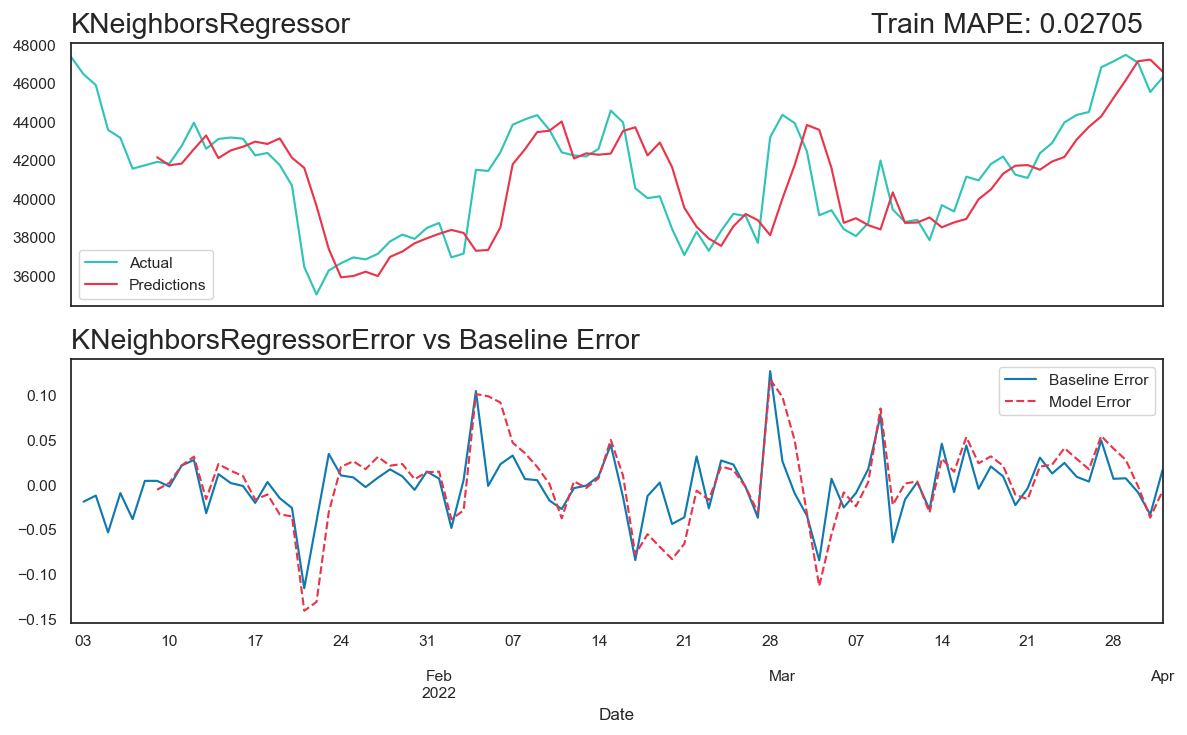

In [57]:
get_predictions(gs_knr, 'KNeighborsRegressor')

### LinearRegressor

In [58]:
pipe_lr = make_pipeline(SelectKBest(f_regression),
                    LinearRegression())

## Change params as needed
params_lr = {
    'selectkbest__k':[10,20,30,40,45,50,55,60],
}


# Setting up the grid search
gs_lr = GridSearchCV(pipe_lr, 
                      params_lr, 
                      n_jobs=-1, 
                      cv=tscv,
                      scoring=score_func,
                      refit=True
                     )

gs_lr.fit(X, Y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=7, n_splits=11, test_size=1),
             estimator=Pipeline(steps=[('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x11f666940>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [10, 20, 30, 40, 45, 50, 55, 60]},
             scoring='neg_mean_absolute_percentage_error')

In [59]:
gs_lr.best_params_


{'selectkbest__k': 20}

In [60]:
best_estimator_lr = gs_lr.best_estimator_


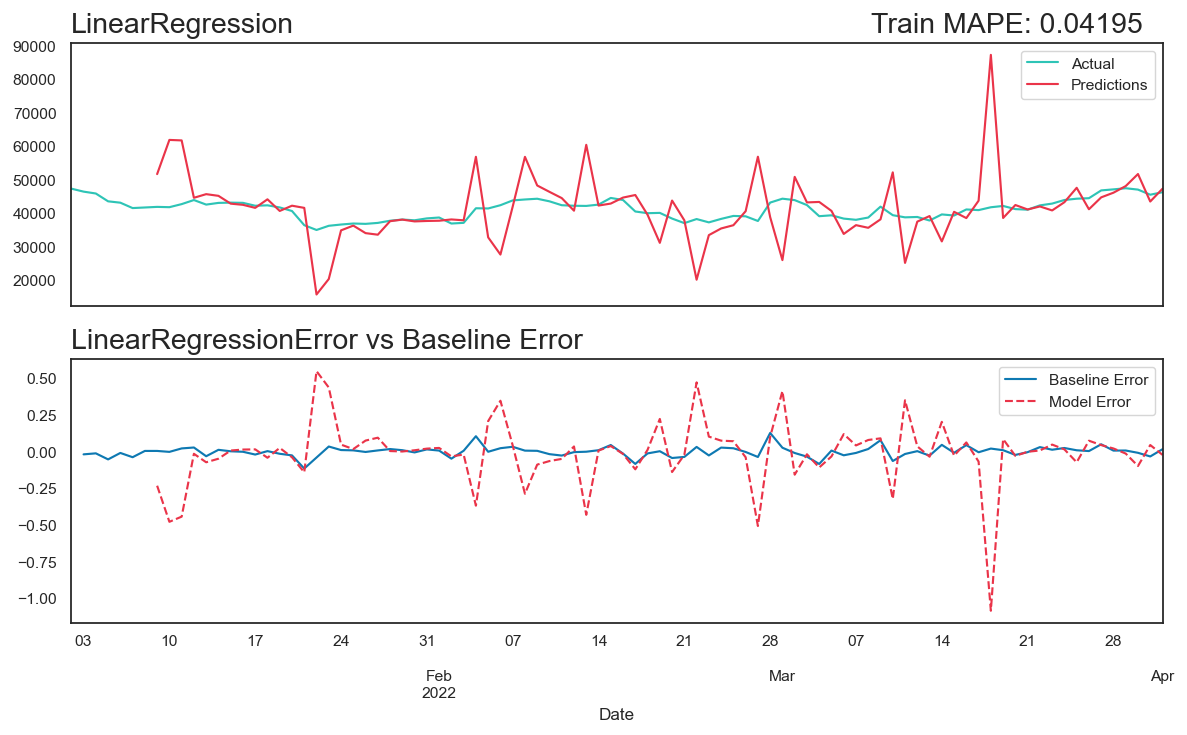

In [61]:
get_predictions(gs_lr, 'LinearRegression')

### RandomForestRegressor

In [62]:
pipe_rfr = make_pipeline(SelectKBest(f_regression),
                    RandomForestRegressor(random_state=RANDOM_STATE))

## Change params as needed
params_rfr = {
    'selectkbest__k':[30],
    'randomforestregressor__max_depth': [3],
    'randomforestregressor__n_estimators': [100]
}


# Setting up the grid search
gs_rfr = GridSearchCV(pipe_rfr, 
                      params_rfr, 
                      n_jobs=-1, 
                      cv=tscv,
                      scoring=score_func,
                      refit=True
                     )

gs_rfr.fit(X, Y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=7, n_splits=11, test_size=1),
             estimator=Pipeline(steps=[('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x11f666940>)),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=9))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__max_depth': [3],
                         'randomforestregressor__n_estimators': [100],
                         'selectkbest__k': [30]},
             scoring='neg_mean_absolute_percentage_error')

In [63]:
gs_rfr.best_params_


{'randomforestregressor__max_depth': 3,
 'randomforestregressor__n_estimators': 100,
 'selectkbest__k': 30}

In [64]:
best_estimator_rfr = gs_rfr.best_estimator_


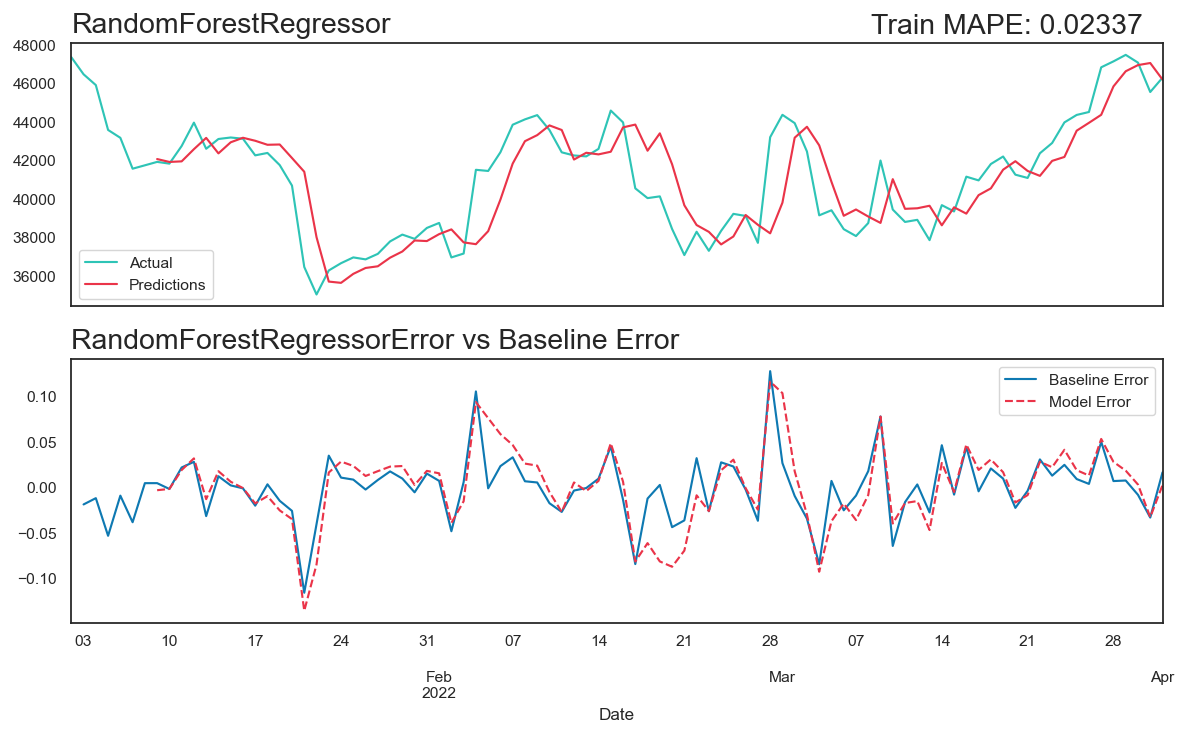

In [65]:
get_predictions(gs_rfr, 'RandomForestRegressor')

## Get Feature Importance

In [66]:
dtr_feats = best_estimator_dtr.named_steps['selectkbest'].get_support() #.steps[2][1].get_support()
dtr_feats_ = [x_cols[i] for i in range(len(dtr_feats)) if dtr_feats[i]==True]
dtr_feat_importance = pd.DataFrame([dtr_feats_,gs_dtr.best_estimator_.named_steps.decisiontreeregressor.feature_importances_]).T.sort_values(by=1,ascending=False)[0:3]

In [67]:
#gs_dtr.best_estimator_.named_steps.decisiontreeregressor.feature_importances_

In [68]:
#gs_dtr.best_estimator_.named_steps.decisiontreeregressor.n_features_in_

In [69]:
## Sorted K Best
#pd.DataFrame([gs_dtr.best_estimator_.named_steps['selectkbest'].scores_,x_cols]).T\
#            .sort_values(by=0, ascending=True)

In [70]:
#best_estimator_dtr.named_steps['selectkbest'].get_feature_names_out()

In [71]:
#[x_cols[i] for i in range(len(dtr_feats)) if dtr_feats[i]==True]

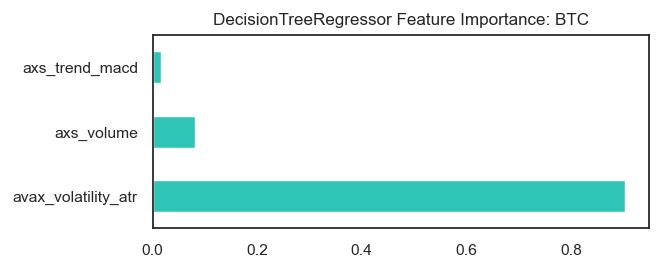

In [72]:
fig, ax = plt.subplots(figsize=(5,2))
dtr_feat_importance.reset_index(drop=True).set_index(0).plot(kind='barh', ax=ax)

ax.set_ylabel(None)
ax.legend([], frameon=False)
plt.title('DecisionTreeRegressor Feature Importance: BTC')
plt.show()

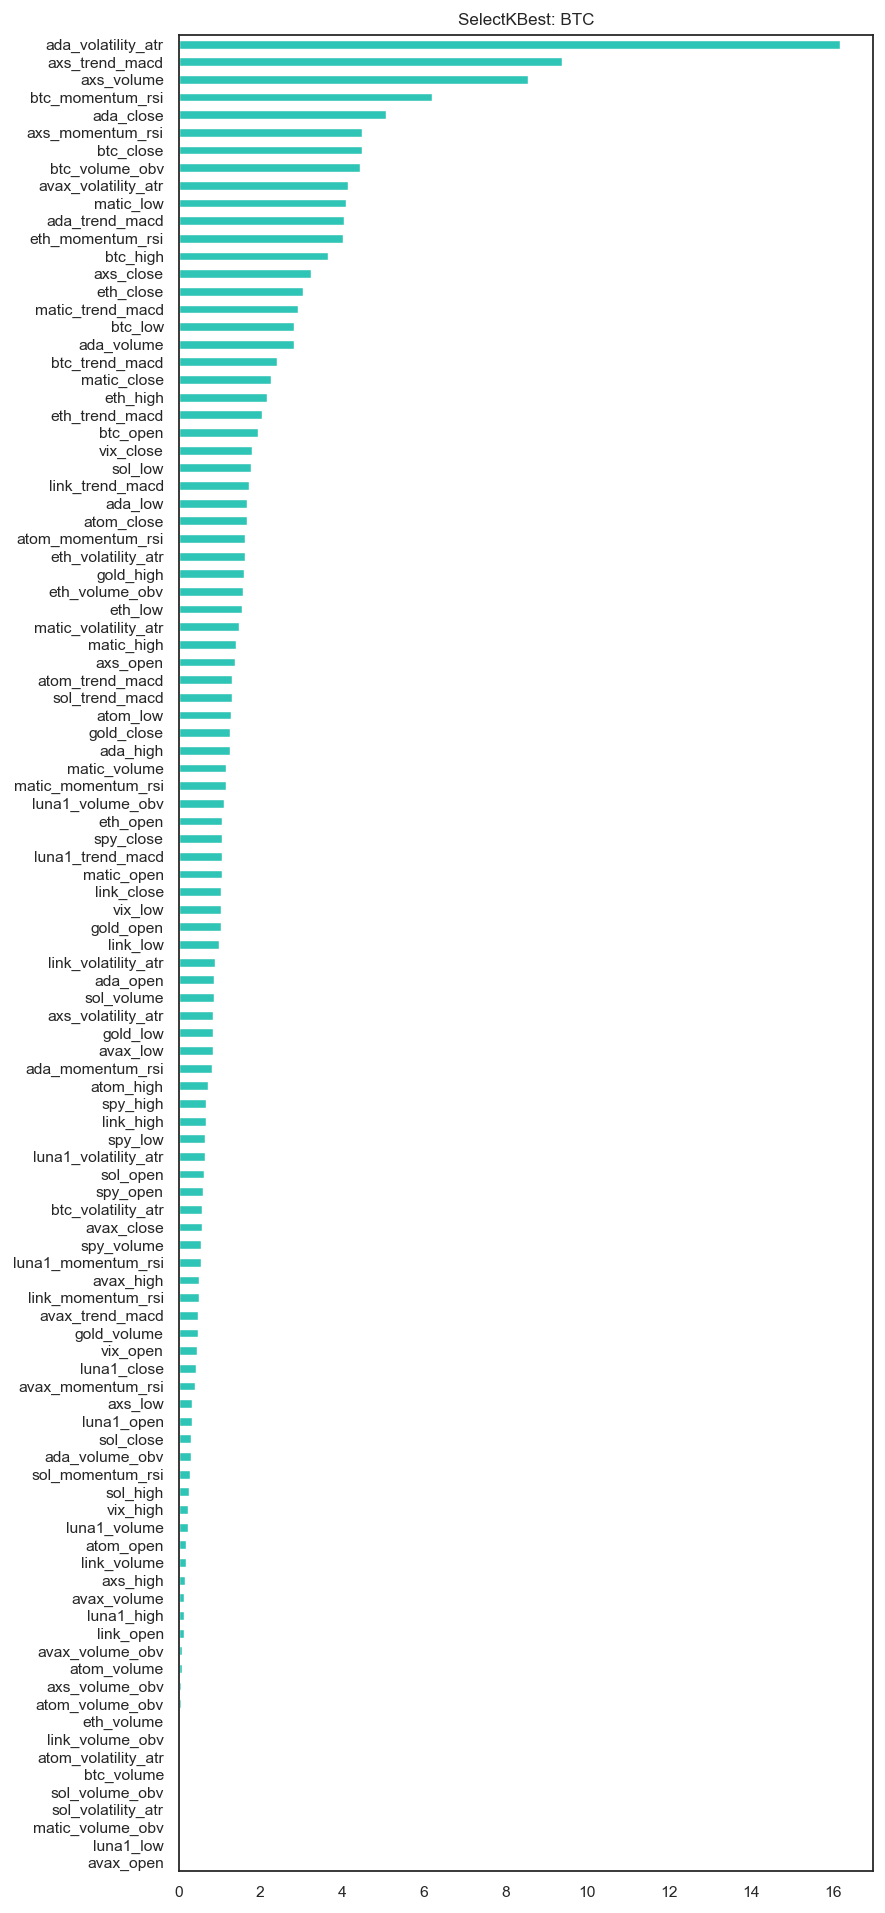

In [73]:
fig, ax = plt.subplots(figsize=(7,19))
pd.DataFrame([gs_dtr.best_estimator_.named_steps['selectkbest'].scores_,x_cols]).T\
            .sort_values(by=0, ascending=True)\
            .reset_index(drop=True).set_index(1)\
            .plot(kind='barh', ax=ax)

ax.set_ylabel(None)
ax.legend([], frameon=False)
plt.title('SelectKBest: BTC')
plt.show()

## SKForecast

In [74]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection_statsmodels import grid_search_sarimax


In [75]:
df_tt_skf = df_tt.copy()
df_pr_skf = df_forprediction.copy()

### DecisionTreeRegressor

In [76]:
fpipe_dt = make_pipeline(StandardScaler(),
                    SelectKBest(f_regression),
                    DecisionTreeRegressor(random_state=RANDOM_STATE))

## Change params as needed
fparams_dt = {
    'selectkbest__k':[10,20,30,40,45,50,55,60,70],
    'decisiontreeregressor__max_depth': [1,2,3,4,5],
}


forecaster_dt = ForecasterAutoreg(
                regressor = fpipe_dt,
                lags = 1
             )
lags_grid = [21]

results_grid_dt = grid_search_forecaster(
                        forecaster  = forecaster_dt,
                        y           = df_tt_skf['Y'],
                        exog        = df_tt_skf[x_cols],
                        param_grid  = fparams_dt,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        refit       = True,
                        metric      = 'mean_absolute_percentage_error',
                        initial_train_size = int(len(df_tt_skf)*0.5),
                        return_best = True,
                        verbose     = False
                    )



Number of models compared: 45


loop lags_grid: 100%|███████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] 
  Parameters: {'decisiontreeregressor__max_depth': 4, 'selectkbest__k': 60}
  Backtesting metric: 0.049659263476336535



In [77]:
#`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
#  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] 
#  Parameters: {'decisiontreeregressor__max_depth': 4, 'selectkbest__k': 60}
#  Backtesting metric: 0.049659263476336535

forecaster_dt = ForecasterAutoreg(
                regressor = make_pipeline(StandardScaler(),
                    SelectKBest(f_regression, k=60),
                    DecisionTreeRegressor(random_state=RANDOM_STATE, max_depth=4)),
                lags = 1
             )

forecaster_dt.fit(y=df_tt_skf['Y'], exog=df_tt_skf[x_cols])


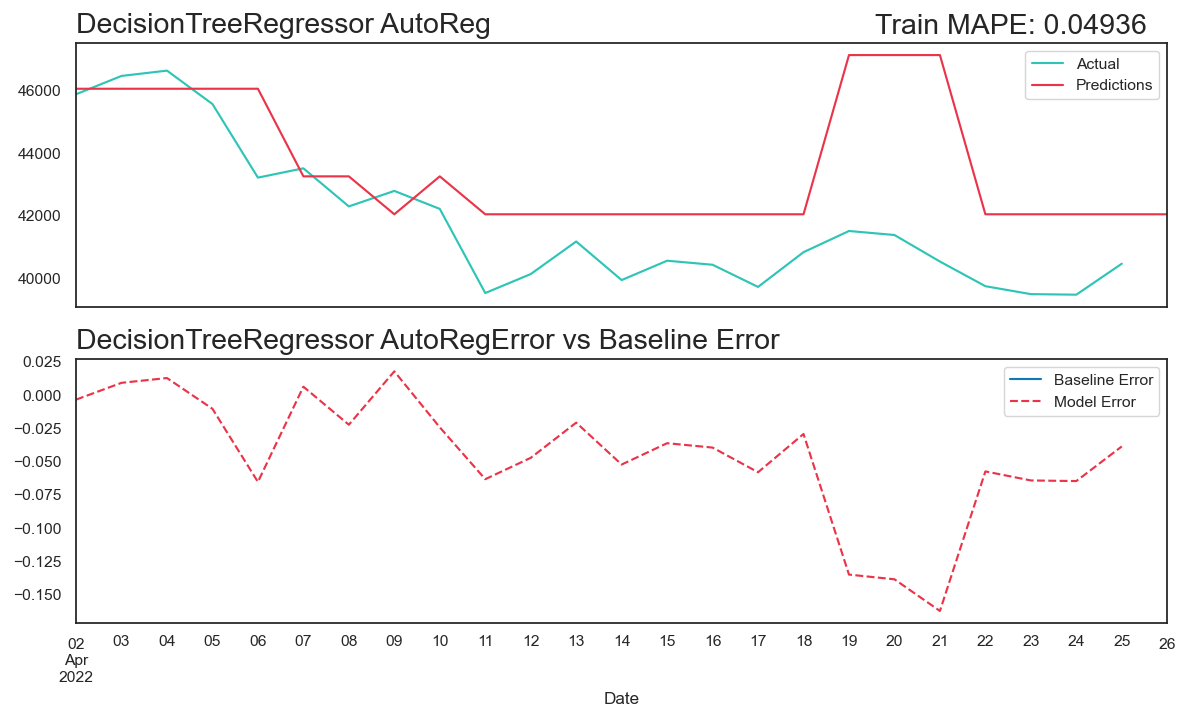

In [84]:
steps = len(df_pr_skf)
predictions_dtr = pd.DataFrame(forecaster_dt.predict(steps=steps, exog=df_pr_skf[x_cols]))
predictions_dtr = predictions_dtr.set_index(df_pr_skf.index)

plot_predictions(predictions_dtr['pred'], df_pr_skf.loc[:,'Y'], 'DecisionTreeRegressor AutoReg', mean_absolute_percentage_error(df_pr_skf['Y'][:-1],predictions_dtr['pred'][:-1]))


### XGBRegressor

In [79]:
fparams_xgb = {
    'selectkbest__k':[30],
    'xgbregressor__learning_rate': [.1],
    'xgbregressor__max_depth': [3],
    'xgbregressor__n_estimators': [100],
    
    
}

pipe_xgb = make_pipeline(StandardScaler(),
                    SelectKBest(f_regression),
                    XGBRegressor(random_state=RANDOM_STATE))


In [80]:
forecaster_xgb = ForecasterAutoreg(
                regressor = pipe_xgb,
                lags = 1
             )
lags_grid = [21]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster_xgb,
                        y           = df_tt_skf['Y'],
                        exog        = df_tt_skf[x_cols],
                        param_grid  = fparams_xgb,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        refit       = True,
                        metric      = 'mean_absolute_percentage_error',
                        initial_train_size = int(len(df_tt_skf)*0.5),
                        return_best = True,
                        verbose     = False
                    )

#results_grid = grid_search_forecaster(
#                        forecaster  = forecaster,
#                        y           = df_tt_skf['Y'],
#                        exog        = df_tt_skf[x_cols],
#                        param_grid  = param_grid,
#                        lags_grid   = lags_grid,
#                        steps       = 10,
#                        refit       = True,
#                        metric      = 'mean_absolute_percentage_error',
#                        initial_train_size = int(len(df_tt_skf)*0.5),
#                        return_best = True,
#                        verbose     = False
#                    )


Number of models compared: 1


loop lags_grid: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  4.83it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] 
  Parameters: {'selectkbest__k': 30, 'xgbregressor__learning_rate': 0.1, 'xgbregressor__max_depth': 3, 'xgbregressor__n_estimators': 100}
  Backtesting metric: 0.039236920276517984



In [81]:
#`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
#  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] 
#  Parameters: {'selectkbest__k': 30, 'xgbregressor__learning_rate': 0.1, 'xgbregressor__max_depth': 3}
#  Backtesting metric: 0.039236920276517984

forecaster_g = ForecasterAutoreg(
                regressor = make_pipeline(StandardScaler(),
                    SelectKBest(f_regression, k=30),
                    XGBRegressor(random_state=RANDOM_STATE, 
                                         learning_rate=.1,
                                         max_depth=3,
                                         n_estimators=100),
                                         ),
                lags = 1
             )

forecaster_g.fit(y=df_tt_skf['Y'], exog=df_tt_skf[x_cols])


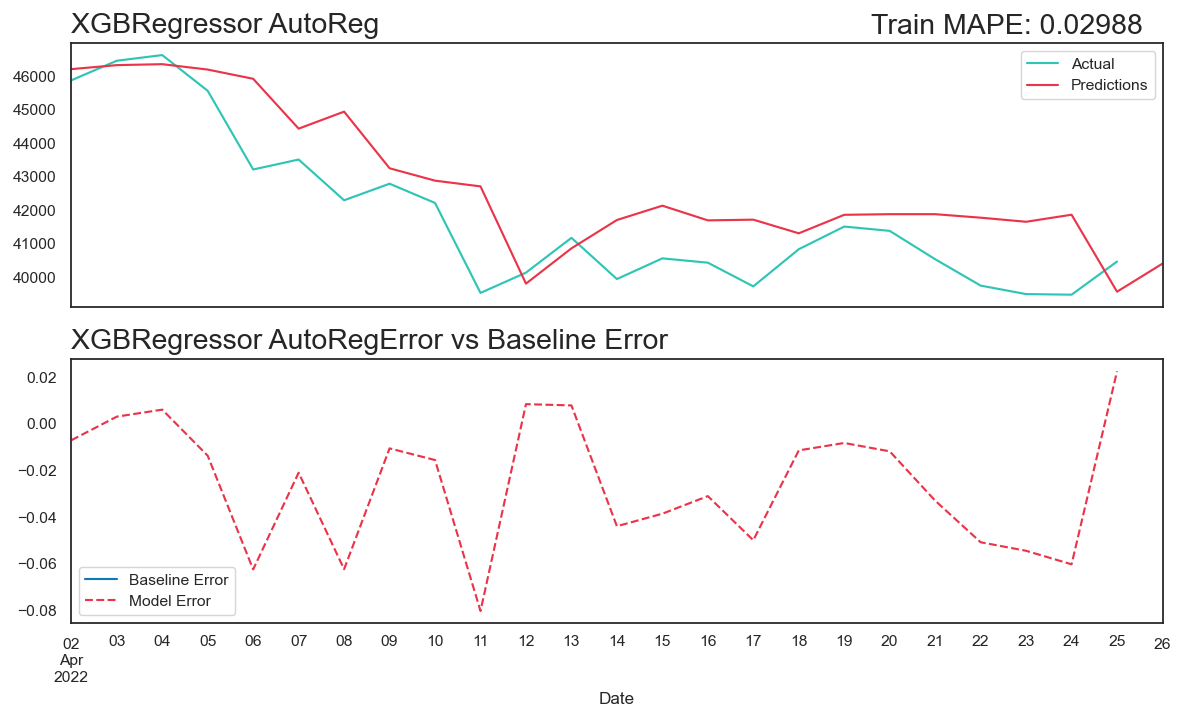

In [83]:
steps = len(df_pr_skf)
predictions = pd.DataFrame(forecaster_g.predict(steps=steps, exog=df_pr_skf[x_cols]))
predictions = predictions.set_index(df_pr_skf.index)

plot_predictions(predictions['pred'], df_pr_skf.loc[:,'Y'], 'XGBRegressor AutoReg', mean_absolute_percentage_error(df_pr_skf['Y'][:-1],predictions['pred'][:-1]))
